In [58]:
#import requiered libraries
import os
import warnings
import sys
from matplotlib import pyplot
import dvc.api
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet, LogisticRegression
from sklearn.preprocessing import LabelEncoder
from fast_ml.model_development import train_valid_test_split
from sklearn.tree import DecisionTreeClassifier
from urllib.parse import urlparse
from sklearn import preprocessing


In [49]:
import warnings
warnings.filterwarnings('ignore')

In [51]:
sys.path.append(os.path.abspath(os.path.join('../scripts')))
from train_classifiers import TrainingClassifier 


In [26]:
cleaned_df  = pd.read_csv('../data/clean_data.csv')

In [6]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1243 entries, 0 to 1242
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   1243 non-null   int64 
 1   auction_id   1243 non-null   object
 2   experiment   1243 non-null   object
 3   date         1243 non-null   object
 4   hour         1243 non-null   int64 
 5   device_make  1243 non-null   object
 6   platform_os  1243 non-null   int64 
 7   browser      1243 non-null   object
 8   aware        1243 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 87.5+ KB


In [52]:
# Load data from dvc using the dvc.api.Dataset class
path = 'data/AdSmartABdata.csv'
repo = 'https://github.com/Group-12-A-B-Hypothesis-Testing/abtest-mlops'
version = 'c1dfb93'
re_url = dvc.api.get_url(path=path, repo=repo, rev=version)
print(re_url)

gdrive://1Qwhs22KV5-hdeMZ-1coPd65tJ7SQ3IJd/9c/00ecff555480cd97b707617d639d3f


In [ ]:
data_os = pd.read_csv(re_url, sep=',')

Label Encoding the Data

In [35]:
def encode_labels(df):
    date_encoder = preprocessing.LabelEncoder()
    device_encoder = preprocessing.LabelEncoder()
    browser_encoder = preprocessing.LabelEncoder()
    experiment_encoder = preprocessing.LabelEncoder()
    aware_encoder = preprocessing.LabelEncoder()
    
    df['date'] = date_encoder.fit_transform(df['date'])
    df['device_make'] = device_encoder.fit_transform(df['device_make'])
    df['browser'] = browser_encoder.fit_transform(df['browser'])
    df['experiment'] = experiment_encoder.fit_transform(df['experiment'])
    df['browser'] = aware_encoder.fit_transform(df['browser'])
    df['aware'] = aware_encoder.fit_transform(df['aware'])
    
    return df    

Spliting the data by browser and platform_os column

In [20]:
def feature_data(df):
    
    browser_feature_df = df[["experiment", "hour", "date", 'device_make', 'browser', 'aware']] 
    platform_feature_df = df[["experiment", "hour", "date", 'device_make', 'platform_os', 'aware']] 

    return browser_feature_df, platform_feature_df

In [24]:
def save_encoded_df(df):
    
    broweser_df, platfrom_df = feature_data(df)
    broweser_df.save_csv("../Data/browser_featured_data.csv")
    platfrom_df.save_csv(platfrom_df, "../data/platform_featured_data.csv")

In [36]:
cleaned_data = encode_labels(cleaned_df)
cleaned_browser_df, cleaned_platform_df = feature_data(cleaned_data)

In [37]:
cleaned_browser_df.head()

,experiment,hour,date,device_make,browser,aware
0,1,2,3,4,2,0
1,1,16,2,13,1,1
2,1,8,4,13,1,0
3,0,4,6,43,4,1
4,0,15,1,13,1,0


In [38]:
Y_col = 'aware'
X_cols = cleaned_browser_df.loc[:, cleaned_browser_df.columns != Y_col].columns

X_train,X_test,y_train,y_test=train_test_split(cleaned_browser_df[X_cols], cleaned_browser_df[Y_col],\
                                                test_size=0.1, random_state=42)

### Training Browser Featured Data

#### Training with Logistic Regression

In [54]:
LR = TrainingClassifier(X_train, X_test,  y_train, y_test, "logistic_regression")
clf2, loss_arr_2, acc_arr_2 = LR.train(5)

step 0: Validation Accuracy of Logistic Regression Classifier is: 0.540
step 0: Validation Loss of Logistic Regression Classifier is: 0.678

step 1: Validation Accuracy of Logistic Regression Classifier is: 0.513
step 1: Validation Loss of Logistic Regression Classifier is: 0.698

step 2: Validation Accuracy of Logistic Regression Classifier is: 0.549
step 2: Validation Loss of Logistic Regression Classifier is: 0.671

step 3: Validation Accuracy of Logistic Regression Classifier is: 0.543
step 3: Validation Loss of Logistic Regression Classifier is: 0.676

step 4: Validation Accuracy of Logistic Regression Classifier is: 0.547
step 4: Validation Loss of Logistic Regression Classifier is: 0.673



step 1: Test Accuracy of Logistic Regression Classifier is: 0.520
Test Metrics
              precision    recall  f1-score   support

           0       0.89      0.52      0.66       111
           1       0.12      0.50      0.19        14

    accuracy                           0.52       125
   macro avg       0.50      0.51      0.42       125
weighted avg       0.81      0.52      0.61       125



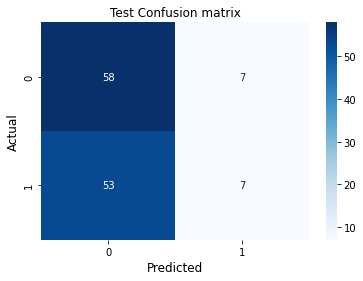

In [55]:
test_acc2, test_loss2, report2, matrix2  = LR.test()

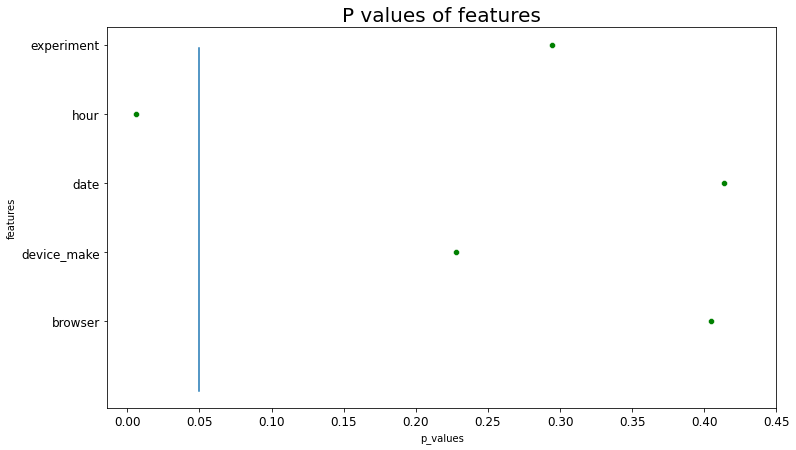

,features,p_values
0,experiment,0.294328
1,hour,0.006117
2,date,0.413474
3,device_make,0.228142
4,browser,0.404565


In [56]:
p_values_df = LR.get_p_values()
LR.plot_pvalues(p_values_df)
p_values_df

The P-value for experiment is 0.3. It is not that much significant, since our significance level is 0.05. Hour is the most important predictor for the Logestic Regression Model with p value 0.001, it is then follwed by device_make then experiment. The least predictor for the Logestic Regression Model is date

In [57]:
# Define Logistic Regression Model
log = LogisticRegression()
# We fit our model with our train data
log.fit(X_train, y_train)
# Then predict results from X_test data
pred_log = log.predict(X_test)

# See First 10 Predictions and They Actual Values
print("Predicted:", pred_log[0:10])
print("Actual:", y_test[0:10])

Predicted: [0 1 0 0 1 0 1 0 0 0]
Actual: 900     1
1003    0
671     0
620     0
926     1
997     0
745     1
938     1
451     0
439     1
Name: aware, dtype: int64


Feature: 0, Score: 0.09975
Feature: 1, Score: 0.02514
Feature: 2, Score: -0.00504
Feature: 3, Score: 0.00252
Feature: 4, Score: -0.04181


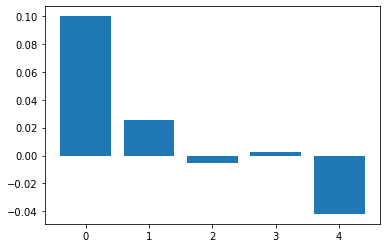

In [59]:
# get importance
importance = log.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()